In [523]:
#Connect 4 AI
import numpy as np
import torch 
import itertools
import random 
from torch import nn
from torch.nn import functional as F
from collections import namedtuple, deque

In [526]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

from d2l import torch as d2l
import random
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import PIL
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T

import gym

In [558]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [397]:
'''
Attempting to teach AI to play connect 4
Board is 7x6, X plays first.
Theoretically, starting player can always force a win. 

internally, 0 = empty, 1 = X, -1 = O

'''



def display_board(board):
    board = board.numpy()
    for row in board:
        for el in row:
            if el == 0:
                print('_', end=' ')
            elif el == 1:
                print('X', end=' ')
            elif el == -1:
                print('O', end=' ')
        print()

def empty_board():
    return torch.tensor([([0 for i in range(7)]) for _ in range(6)]
                        , dtype = torch.float)

b = empty_board()
display_board(b)

_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 


In [398]:
# Need a way to make a move to a specific column of a board
def select_col(board, col):
    return board[:, col]


def add_X(board, col):
    # col should be 0-6
    column = select_col(board, col)
    for i in range(6):
        if column[5-i] == 0:
            column[5-i] = 1 
            return board
    # In case this col is full, the move is illegal and we obtain -10 reward
    return -10
        
def add_O(board, col):
    # col should be 0-6
    column = select_col(board, col)
    for i in range(6):
        if column[5-i] == 0:
            column[5-i] = -1 
            return board
    # In case this col is full, the move is illegal and we obtain -10 reward
    return -10

empt = empty_board()
display_board(add_O(empt, 2))

_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ O _ _ _ _ 


In [399]:
# Next, be able to detect when a game has ended.

def has_ended(b):
    # Returns False when game is still ongoing, True, winner when there is a winner.
    b = b.numpy()
    rows = check_rows(b) # Returns False if no winner, otherwise returns the winner
    cols = check_cols(b)
    diag = check_diag(b)
    
    if rows:
        return rows
    if cols:
        return cols

    return diag
    
def check_rows(b):
    for row in b:
        result = check_row(row)
        if result:
            return result
    return False

def check_row(r):
    for i in range(4):
        if (r[i:i+4] == 4*[1]).all():
            return 'X'
        if (r[i:i+4] == 4*[-1]).all():
            return 'O'
    return False

def check_cols(b):
    for i in range(7):
        col = select_col(b, i)
        result = check_col(col)
        if result:
            return result
    return False

def check_col(r):
    for i in range(3):
        if (r[i:i+4] == 4*[1]).all():
            return 'X'
        if (r[i:i+4] == 4*[-1]).all():
            return 'O'
    return False

def check_diag(b):
    result = check_ud(b)
    if result:
        return result
    return check_du(b)
    
def check_ud(b):
    #Check diagonals going top-left to bot-right
    for col in range(4):
        for row in range(3):
            #starting point = (row, col)
            els = np.array([b[row, col], b[row+1, col+1], b[row+2, col+2], b[row+3, col+3]])
            if (els == 4*[1]).all():
                return 'X'
            if (els == 4*[-1]).all():
                return 'O'
    return False

def check_du(b):
    #Check diagonals going bot-left to top-right
    for col in range(4):
        for row in range(3,6):
            #starting point = (row, col)
            els = np.array([b[row, col], b[row-1, col+1], b[row-2, col+2], b[row-3, col+3]])
            if (els == 4*[1]).all():
                return 'X'
            if (els == 4*[-1]).all():
                return 'O'
    return False

In [400]:
'''
Next: Define a model to select the best move.

Input: Board as 7x6 = 56 inputs. 
Output: Column the net plays in. 

There will be one network, scoring the board for player X.

'''

class MovePolicy:
    '''A class for policies that take a board as input.'''
    def select_action(self, board):
        raise NotImplementedError
    
    def __call__(self, board):
        return self.select_action(board)


def run_simulation(policyX, policyO, plot = True):
    '''Runs a game simulation with the given policies.
    
    The policies are instances of MovePolicies, taking a board as input
    '''
    
    board = empty_board()
    rewardX = 0
    rewardO = 0
    for step in itertools.count():
        # X moves first, then O
        # use the policy to determine the next action
        actionX = policyX(board)
        # perform the action: 
        board = add_X(board, actionX)
        
        if type(board) == int:
            # Illegal move played. Game ends
            rewardX -= 10
            print("Illegal move by X.")
            break
        
        result = has_ended(board)
        if result == 'X':
            rewardX += 100
            print("X IS VICTORIOUS")
            display_board(board)
            break
            
        # potentially: Add a little bit of negative reward for playing a move without winning the game. 
        
        if plot:
            print("X has moved:")
            display_board(board)
            print("")
        # O to make a move
        
        actionO = policyO(board)
        # perform the action: 
        board = add_O(board, actionO)
        
        if type(board) == int:
            # Illegal move played. Game ends
            rewardO -= 10
            print("Illegal move by O.")
            break
        
        result = has_ended(board)
        if result == 'O':
            rewardO += 100
            print("O IS VICTORIOUS")
            display_board(board)
            break
        
    return rewardX, rewardO, step

In [401]:
# Simple policies

class RandomPolicy(MovePolicy):
    def select_action(self, board):
        #Simply return a random column 
        
        return random.choice([0,1,2,3,4,5,6])
    
class CyclePolicy(MovePolicy):
    def __init__(self, x):
        self.cycle = x % 7
        
    def select_action(self, board):
        self.cycle = (self.cycle + 1) % 7
        return self.cycle

In [402]:
# Test if this policy works:

polX = CyclePolicy(0)
polO = CyclePolicy(2)

run_simulation(polX, polO)

X has moved:
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ X _ _ _ _ _ 

X has moved:
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ X X O _ _ _ 

X has moved:
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ X _ _ _ 
_ X X O O _ _ 

X has moved:
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ X X _ _ 
_ X X O O O _ 

O IS VICTORIOUS
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ X X _ _ 
_ X X O O O O 


(0, 100, 3)

In [730]:
# Create a NN to calculate the expected reward given a board. Input: 42 nodes

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(42, 28)
        self.linear2 = torch.nn.Linear(28, 14)
        self.linear4 = torch.nn.Linear(14,7) # 7 Outputs, one for each column.
        self.flatten = torch.nn.Flatten(1)
        self.relu = torch.nn.ReLU()

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear4(x))
        
        return x

In [459]:
# Try it on a single input
policy_net = DQN()
#print(policy_net)

b = empty_board()
#display_board(b)

print(policy_net(b))

tensor([0.1296, 0.1693, 0.1144, 0.0000, 0.0000, 0.0000, 0.0000],
       grad_fn=<ReluBackward0>)


In [486]:
# Create a policy to make moves according to a network

class QNNPolicy(MovePolicy):
    def __init__(self, net):
        self.net = net

    def select_action(self, board):
        # compute the expected reward for each action
        with torch.no_grad():
            expected_reward = self.net(board)
        # select the action with the highest score
        return torch.argmax(expected_reward).item()

In [1000]:
'''
Here, create two nets, one for each player.

Potentially could also use the same net for both, just flip the labels by multiplying with -1

'''

policy_netX = DQN()
policy_netO = DQN()


polX = QNNPolicy(policy_netX)
polO = QNNPolicy(policy_netO)
run_simulation(polX, polO, plot = False)

X IS VICTORIOUS
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ X _ _ 
_ _ _ _ X O _ 
_ _ _ _ X O _ 
_ _ _ _ X O _ 


(100, 0, 3)

In [1059]:
'''
At this point, the nets are stupid. They need training to make intelligent moves.
This is done with Q-learning algorithm.
'''

# Data type to represent state transitions
Transition = namedtuple('Transition',
                        ('board', 'action', 'next_board', 'reward'))

class QOptimizer_Basic:
    def __init__(self, net, lr=1e-4, batch_size=128, gamma=1):
        '''Initialize the algorithm
        
        net:  a policy network that takes the current state s as input
              and returns the Q(s, a) value for each action a
        '''
        self.net = net
        self.gamma = gamma
        self.winreward = 1000 #Rewards for winning the game.
        self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=lr)
        #print(gamma)


    # Implements the Q learning algorithm

    def train(self, num_episodes=10, plot=True):
        '''Train the model using a reinforcement learning algorithm
        
        num_episodes:  number of training episodes to run
        plot:          show learning curves during training
        '''
        
        if plot:
            self.init_stats(num_episodes)
        wins = 0
        losses = 0

        total_steps = 0

        for episode in range(num_episodes):
            # Initialize the environment and state
            board = empty_board()
    
            # Run a single game until it ends. Step counts how many moves have been made
            for step in itertools.count():
                done = False

                # Select and perform an action
                actionX = self.select_action(board, total_steps)
                board_with_X = add_X(board, actionX)
                total_steps += 1
                # If the game has ended, record the rewards. 
                # 100 for winning, -100 for illegal move or losing, 0 otherwise
                
                rewardX, done = self.calculate_rewards(board_with_X)
                #If O ends the game on his next turn, rewardX should be updated to reflect that. 
                
                if not done:
                    next_board = board_with_X 
                else:
                    #Game has ended. Optimize transition and go to next iteration.
                    next_board = None
                    
                    rewardX = torch.tensor([rewardX])
                    actionX = torch.tensor([actionX])
                    transition = Transition(board, actionX, next_board, rewardX)

                    self.optimize_model([transition])
                    
                    if plot:
                        self.update_stats(episode, 2 * step - 1, wins, losses)
                    # Continue to the next episode
                    break
                    
                
                # The opponent gets the chance to make their move as well if the game has not ended yet
                board2 = -1* board_with_X # Negate the board to simulate X choosing again.

                actionO = self.select_action(board, total_steps)

                # Add an X here, since we will multiply with -1 at the end again.
                board_with_O = add_X(board2, actionO)
                total_steps += 1

                rewardO, done = self.calculate_rewards(board_with_O)
                
                #If O wins the game here, X should have negative rewards.
                if rewardO == self.winreward:
                    # Make losing worse than not winning?
                    rewardX =  -0.5*self.winreward
                
                # Set next_board correctly
                if not done:
                    next_board = board_with_O
                else:
                    next_board = None

                # Record both transitions
                rewardO = torch.tensor([rewardO])
                actionO = torch.tensor([actionO])
                transitionO = Transition(board2, actionO, next_board, rewardO)
                
                rewardX = torch.tensor([rewardX])
                actionX = torch.tensor([actionX])
                transitionX = Transition(board, actionX, board_with_X, rewardX)
            
                
                # Perform one step of the optimization:
                # train with the last transition
                self.optimize_model([transitionX])
                self.optimize_model([transitionO])
                    
                if done:
                    if plot:
                        self.update_stats(episode, 2 * step, wins, losses)
                    # Continue to the next episode
                    break
                board = -1 * next_board

    # The gradient descent optimization step

    def optimize_model(self, transitions):
        '''Run a single optimization step of the model given a set of transitions'''
        
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Concatenate as torch tensors
        state_batch = torch.cat(batch.board)
        action_batch = torch.cat(batch.action)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would have
        # been taken for each batch state according to policy_net
        state_action_values = self.net(state_batch).gather(-1, action_batch)

        # Compute the expected Q values
        expected_state_action_values = \
            self.compute_expected_state_action_values(batch.next_board, batch.reward)

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


    # Helper functions for the algorithm

    def select_action(self, board, total_steps):
        '''Use the network to select the next step given the current state'''
        
        # Compute the expected reward for each action
        with torch.no_grad():
            expected_reward = self.net(board)

        # Select the action with the highest score
        return torch.argmax(expected_reward).item()

    def calculate_rewards(self, b):
        if type(b) == int:
            # Illegal move played. Game ends, punished heavily
            return -100, True
            
        elif has_ended(b) == 'X':
            # X wins
            return self.winreward, True
        
        else: 
            # No winner, game continues. No reward
            return 0, False

            

    def compute_expected_state_values(self, states):
        '''Compute Q(s_t+1) for the list of states=[s_t+1]'''
        with torch.no_grad():
            # Use the maximum value of the two possible actions
            return torch.max(self.net(states))

    def compute_expected_state_action_values(self, next_states, rewards):
        '''Compute the expected state-action values Q(s_t, a)
        
        Given next_states=[s_{t+1}] and action rewards=[r_a],
        this function returns the expected Q(s_t, a) values.
        '''

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would have been the one after which simulation ended)
        non_final_mask = torch.tensor([s is not None for s in next_states],
                                      device=device, dtype=torch.bool)
        if any(non_final_mask):
            non_final_next_states = torch.cat([s for s in next_states if s is not None])
        
        # Compute Q(s_{t+1}) for all next states.
        next_state_values = torch.zeros(len(next_states), device=device)
        if any(non_final_mask):
            next_state_values[non_final_mask] = self.compute_expected_state_values(non_final_next_states).detach()

        # Compute the expected Q(s_t, a) values by adding the action reward.
        next_state_action_values = (next_state_values * self.gamma) + torch.cat(rewards)

        # Return shape: [batch_size]
        return next_state_action_values


    # Plotting code
 
    def init_stats(self, num_episodes):
        '''Initialize the plot and running average'''
        self.animator = d2l.Animator(xlabel='episode', xlim=[1, num_episodes], figsize=(10, 5),
                                     legend=['number of moves', 'moving average'])
        self.duration_log = deque(maxlen=25)
        self.winrate_log = deque(maxlen=25)

    def update_stats(self, episode, steps, wins, losses):
        '''Update the moving average and plot the results'''
        
        self.duration_log.append(steps)

        #winrate = wins/(wins + losses)
        #self.winrate_log.append(winrate)

        # Plot the results
        if len(self.duration_log) == self.duration_log.maxlen:
            average_duration = np.mean(self.duration_log)
        else:
            average_duration = None
            
        if len(self.winrate_log) == self.winrate_log.maxlen:
            average_winrate = np.mean(self.winrate_log)
        else:
            average_winrate = None
        self.animator.add(episode + 1, (steps, average_duration)) #, average_duration, ))

tensor([0.0000, 0.1413, 0.0000, 0.0578, 0.0000, 0.0000, 0.0000],
       grad_fn=<ReluBackward0>)
tensor([0.0000, 0.0879, 0.0000, 0.0630, 0.0000, 0.0000, 0.0000],
       grad_fn=<ReluBackward0>)


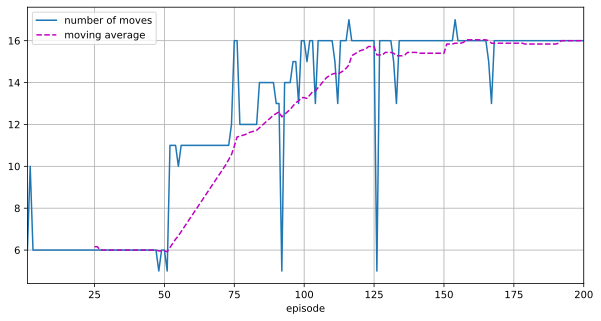

In [1060]:
b = empty_board()
policy_net = DQN() #uncomment to refresh network.
a = policy_net(b)
QOptimizer_Basic(policy_net).train(num_episodes=200)
print(a)
print(policy_net(b))

Het probleem nu lijkt te zijn dat O geen negatieve rewards krijgt als X wint. Daardoor exploderen de rewards gigantisch na een langere tijd getraind te hebben, wat ik nog niet helemaal begrijp. Het is echt zoeken naar de balans tussen rewards voor winnen tegenover negatieve rewards voor verliezen en negatieve rewards voor illegale moves.

In [1067]:
# The network is now trained to play as X. Time to see how it performs!
b = empty_board()

totalmoves = 0

In [1068]:
botmoveX=torch.argmax(policy_net(b)).item()

print(policy_net(b))

print("The bot plays X in column {}! The board is as follows.".format(botmoveX)) 
b = add_X(b, botmoveX)
if type(b) == int:
    print("Illegal move by the bot! The game lasted for {} turns".format(totalmoves))
    assert False
totalmoves  +=1
display_board(b)
b = -1 * b

print(policy_net(b))
botmoveO = torch.argmax(policy_net(b)).item()
print("The bot plays O in column {}! The board is as follows.".format(botmoveO)) 
b = add_X(b, botmoveO)
if type(b) == int:
    print("Illegal move by the bot! The game lasted for {} turns".format(totalmoves))
    assert False
b = -1*b
totalmoves += 1
display_board(b)

tensor([0.0000, 0.0879, 0.0000, 0.0630, 0.0000, 0.0000, 0.0000],
       grad_fn=<ReluBackward0>)
The bot plays X in column 1! The board is as follows.
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ X _ _ _ _ _ 
tensor([0.0000, 0.0638, 0.0000, 0.1015, 0.0000, 0.0000, 0.0000],
       grad_fn=<ReluBackward0>)
The bot plays O in column 3! The board is as follows.
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ X _ O _ _ _ 


In [799]:
b = add_O(b, 2)
display_board(b)

_ _ O _ _ _ _ 
_ _ X _ _ _ O 
_ _ O _ _ _ O 
_ _ X _ _ _ O 
_ _ X _ _ _ X 
_ O X _ _ _ X 


In [710]:
polX = QNNPolicy(policy_net)
polO = RandomPolicy()
run_simulation(polX, polO)

X has moved:
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ X 

X has moved:
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ X 
_ _ _ _ _ O X 

X has moved:
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ X 
_ _ _ _ _ O X 
_ _ _ _ _ O X 

X IS VICTORIOUS
_ _ _ _ _ _ _ 
_ _ _ _ _ _ _ 
_ _ _ _ _ _ X 
_ _ _ _ _ _ X 
_ _ _ _ _ O X 
_ _ _ _ O O X 


(100, 0, 3)

In [728]:
# Adding randomness

class QOptimizer_Epsilon(QOptimizer_Basic):
    def __init__(self, *args, eps_start=0.8, eps_end=0.05, eps_decay=2000, **kwargs):
        '''Initialize the algorithm
        
        eps_start:  the initial epsilon value at step 0
        eps_end:    the final epsilon value at step eps_decay
        eps_decay:  the final step of the epsilon decay
        '''
        super().__init__(*args, **kwargs)
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay

    def select_action(self, state, total_steps):
        '''Use the network to select the next step given the current state'''
        
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
                        math.exp(-1. * total_steps / self.eps_decay)

        # TODO Return an action given the current state,
        #      expected output shape: [batch_size, 1], dtype: long
        
        if sample > eps_threshold:
            return random.choice([0,1,2,3,4,5,6])
        else:
            with torch.no_grad():
                expected_reward = self.net(state)
            return torch.argmax(expected_reward).item()
            

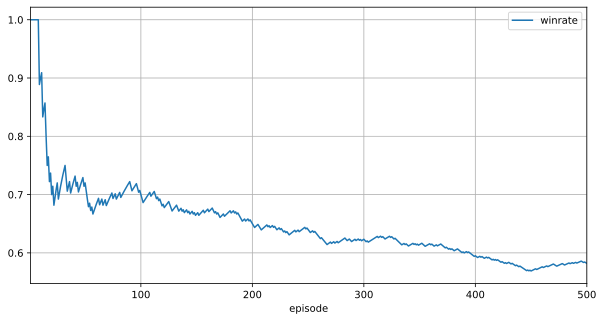

In [741]:
#Training with Epsilon things


policy_net = DQN().to(device)
QOptimizer_Epsilon(policy_net).train(num_episodes=500)
